# Sprint 2: Schema reDesign

#### Initial configuration and conection to duckdb and ducklake

In [1]:
import duckdb
import pandas as pd
import os
import glob

# --- 1. Configuration & Paths ---
RAW_DATA_PATH = '../data/raw/'
LAKEHOUSE_PATH = '../data/lakehouse'
METADATA_PATH = os.path.join(LAKEHOUSE_PATH, 'metadata.duckdb')

# Create the base directory if it doesn't exist
os.makedirs(LAKEHOUSE_PATH, exist_ok=True)

# --- 2. Initialize DuckDB & Load DuckLake Extension ---
# Connect to in-memory DuckDB (Compute Layer)
con = duckdb.connect(database=':memory:')

print("--- Initializing DuckLake Extension ---")

# ✅ ACTIVATE DUCKLAKE: This downloads/installs the extension if missing
# and loads it into the current session.
try:
    con.execute("INSTALL ducklake;")
    con.execute("LOAD ducklake;")
    print("✅ Extension 'ducklake' loaded successfully.")
except Exception as e:
    print(f"❌ Error loading 'ducklake'. Make sure the extension is available in your environment.\nError: {e}")

--- Initializing DuckLake Extension ---
✅ Extension 'ducklake' loaded successfully.


#### Attach the Catalog and Schema Management

In [2]:
# --- 3. Attach the Catalog ---
# We attach the persistent storage. 
# Note: Depending on your specific DuckLake version, the syntax for ATTACH might vary slightly.
# This assumes standard syntax where we point to the metadata file.
con.execute(f"ATTACH 'ducklake:{METADATA_PATH}' AS lakehouse")
print(f"✅ Lakehouse catalog attached at: {METADATA_PATH}")

# --- 4. Schema Management ---
# Create logical schemas within the managed catalog
schemas = ['bronze', 'silver', 'gold']
for schema in schemas:
    con.execute(f"CREATE SCHEMA IF NOT EXISTS lakehouse.{schema}")
print(f"✅ Schemas ready: {', '.join(schemas)}")

✅ Lakehouse catalog attached at: ../data/lakehouse\metadata.duckdb
✅ Schemas ready: bronze, silver, gold


---
# Bronze Layer

### Download data

- Coordinates

In [ ]:
import geopandas as gpd
from pyspainmobility import Zones

# --- 1. CONFIGURATION & PATHS ---
# Define the target directory for Raw data
RAW_MITMA_PATH = '../data/raw/mitma'

# Create the directory if it does not exist
os.makedirs(RAW_MITMA_PATH, exist_ok=True)

# Dictionary mapping the library parameter to the desired filename
zones_config = {
    "municipios": "municipios_poligon"  # Municipalities
}

print(f"--- 🌍 Starting Geo Ingestion to: {RAW_MITMA_PATH} ---")

# --- 2. PROCESSING LOOP ---
for zone_type, filename in zones_config.items():
    print(f"-> Processing: {zone_type}...")
    
    try:
        # A. Fetch Data from API
        # We initialize the Zones object and get the GeoDataFrame
        zones_api = Zones(zones=zone_type, version=2)
        gdf = zones_api.get_zone_geodataframe()
        
        # Ensure CRS is set to WGS84 (Standard Lat/Lon) just in case
        if gdf.crs is None:
            gdf.set_crs(epsg=4326, inplace=True)

        # B. Convert Geometry to WKT (Well-Known Text)
        # DuckDB needs the polygon as a text string (e.g., "POLYGON((...))") 
        # to load it into a CSV. We do NOT calculate centroids here.
        gdf['wkt_polygon'] = gdf.geometry.to_wkt()
        
        # C. Prepare for Export
        # We drop the original binary 'geometry' column because it cannot be saved to CSV.
        # We cast the GeoDataFrame to a standard Pandas DataFrame.
        df_export = pd.DataFrame(gdf.drop(columns=['geometry']))

        # D. Save to CSV
        output_path = os.path.join(RAW_MITMA_PATH, f"{filename}.csv")
        
        # We use semicolon ';' separator to avoid conflicts with commas inside the WKT string
        df_export.to_csv(output_path, index=False, sep=';', encoding='utf-8')
        
        print(f"   ✅ Successfully saved: {output_path}")
        print(f"   📊 Rows ingested: {len(df_export)}")

    except Exception as e:
        print(f"   ❌ Error processing {zone_type}: {e}")

print("\n✨ Geo Ingestion Complete.")

### Inserting the data into the partitioned table

In [6]:
import os
import glob
import time
import re

# --- Configuration ---
MITMA_PATH = os.path.join(RAW_DATA_PATH, 'mitma', '*_Viajes_municipios.csv.gz')
files = sorted(glob.glob(MITMA_PATH)) # Sort to process in order

print(f"\n--- 🔄 Batched Upsert Ingestion (Bronze) ---")
print(f"-> Found {len(files)} files to process.")

# 1. Ensure Table Exists (Empty Structure)
# We create it if it doesn't exist, using the first file to infer schema
if files:
    # Check if table exists
    table_check = con.execute("SELECT count(*) FROM information_schema.tables WHERE table_name = 'mobility_sample_week' AND table_schema = 'bronze'").fetchone()[0]
    
    if table_check == 0:
        print("-> Creating table structure...")
        con.execute(f"""
            CREATE TABLE lakehouse.bronze.mobility_sample_week AS 
            SELECT 
                *,
                CURRENT_TIMESTAMP AS ingestion_timestamp,
                'MITMA_URL' AS source_url
            FROM read_csv_auto('{files[0]}', filename=true, all_varchar=true)
            LIMIT 0;
        """)
        # Configure Partitioning immediately
        con.execute("ALTER TABLE lakehouse.bronze.mobility_sample_week SET PARTITIONED BY (fecha);")

# 2. Batch Processing Loop
total_start = time.time()

for i, file_path in enumerate(files):
    file_name = os.path.basename(file_path)
    loop_start = time.time()
    
    # --- A. Extract Date from Filename (Python side) ---
    # Assuming filename format: '20231003_Viajes_municipios.csv.gz'
    # We look for the first 8 digits
    match = re.search(r'(\d{8})', file_name)
    
    if match:
        date_str = match.group(1) # e.g., "20231003"
        
        try:
            # --- B. The "Upsert" (Delete existing partition first) ---
            # This ensures idempotency: if you run this script twice, you won't get duplicate data.
            con.execute(f"DELETE FROM lakehouse.bronze.mobility_sample_week WHERE fecha = '{date_str}'")
            
            # --- C. The Insert (With Error Handling) ---
            query_insert = f"""
                INSERT INTO lakehouse.bronze.mobility_sample_week 
                SELECT 
                    *,
                    CURRENT_TIMESTAMP AS ingestion_timestamp,
                    'https://www.transportes.gob.es/...' AS source_url
                FROM read_csv_auto(
                    '{file_path}', 
                    filename=true, 
                    all_varchar=true, 
                    ignore_errors=true  -- Handle corrupted rows
                );
            """
            con.execute(query_insert)
            
            elapsed = time.time() - loop_start
            print(f"[{i+1}/{len(files)}] ✅ Upserted {date_str} (File: {file_name}) in {elapsed:.2f}s")
            
        except Exception as e:
            print(f"[{i+1}/{len(files)}] ❌ Error processing {file_name}: {e}")
            
    else:
        print(f"[{i+1}/{len(files)}] ⚠️ Skipped {file_name} (Could not extract date)")

print(f"\n✨ Ingestion Complete in {(time.time() - total_start):.2f} seconds.")

# --- Validation ---
print("\n[Final Count]:")
con.execute("SELECT COUNT(*) FROM lakehouse.bronze.mobility_sample_week").df()


--- 🔄 Batched Upsert Ingestion (Bronze) ---
-> Found 8 files to process.
[1/8] ✅ Upserted 20231001 (File: 20231001_Viajes_municipios.csv.gz) in 9.28s
[2/8] ✅ Upserted 20231002 (File: 20231002_Viajes_municipios.csv.gz) in 7.93s
[3/8] ✅ Upserted 20231003 (File: 20231003_Viajes_municipios.csv.gz) in 5.72s
[4/8] ✅ Upserted 20231004 (File: 20231004_Viajes_municipios.csv.gz) in 6.48s
[5/8] ✅ Upserted 20231005 (File: 20231005_Viajes_municipios.csv.gz) in 6.45s
[6/8] ✅ Upserted 20231006 (File: 20231006_Viajes_municipios.csv.gz) in 6.31s
[7/8] ✅ Upserted 20231007 (File: 20231007_Viajes_municipios.csv.gz) in 6.48s
[8/8] ✅ Upserted 20231008 (File: 20231008_Viajes_municipios.csv.gz) in 6.70s

✨ Ingestion Complete in 55.35 seconds.

[Final Count]:


,count_star()
0,84796712


#### Data and Schema Preview of Mobility Files

In [7]:
# --- INSPECTION & METADATA CHECK ---
print("\n--- 🔍 INSPECTION: Mobility Table ---")

# 1. Content Preview
# Verify that 'origen' and 'destino' columns look like municipal codes (5 digits)
print("\n[1] Data Preview (First 5 rows):")
con.execute("SELECT * FROM lakehouse.bronze.mobility_sample_week  LIMIT 5").df()


--- 🔍 INSPECTION: Mobility Table ---

[1] Data Preview (First 5 rows):


,fecha,periodo,origen,destino,distancia,actividad_origen,actividad_destino,estudio_origen_posible,estudio_destino_posible,residencia,renta,edad,sexo,viajes,viajes_km,filename,ingestion_timestamp,source_url
0,82,19recu40,10-50,no_frecuente,casnte,nouente,no,9-15,27,107,10-15,25-45,hombre,4.878udio11002,61,../data/raw/mitma\20231002_Viajes_municipios.c...,2025-12-07 17:56:45.018995+01:00,https://www.transportes.gob.es/...
1,82,19recu40,10-50,no_frecuente,cas,no,no,07,10-15,65-44.73,10-15,25-45,hombre,4.878udio11002,61,../data/raw/mitma\20231002_Viajes_municipios.c...,2025-12-07 17:56:45.018995+01:00,https://www.transportes.gob.es/...
2,82,19recu40,10-50,no_frecuente,cas,no,no,10-15,4449,65-07,10-15,25-45,hombre,4.878udio11002,61,../data/raw/mitma\20231002_Viajes_municipios.c...,2025-12-07 17:56:45.018995+01:00,https://www.transportes.gob.es/...
3,82,19recu40,10-50,no_frecuente,cas,no,noo,no,00o,07,106881,07011,0.5-2,trabajo_estudio11002,61,../data/raw/mitma\20231002_Viajes_municipios.c...,2025-12-07 17:56:45.018995+01:00,https://www.transportes.gob.es/...
4,202310027040,10-50,frecuente,frecte,no,no,07,10-,07,62.,>15,0-25,NA,8.819,108.172,../data/raw/mitma\20231002_Viajes_municipios.c...,2025-12-07 17:56:45.018995+01:00,https://www.transportes.gob.es/...


In [8]:
# 2. Schema Check
# Confirm column names and ensure types are currently VARCHAR (as expected for Bronze)
print("\n[2] Schema (Columns & Types):")
con.execute("DESCRIBE lakehouse.bronze.mobility_sample_week ").df()


[2] Schema (Columns & Types):


,column_name,column_type,null,key,default,extra
0,fecha,VARCHAR,YES,None,None,None
1,periodo,VARCHAR,YES,None,None,None
2,origen,VARCHAR,YES,None,None,None
3,destino,VARCHAR,YES,None,None,None
4,distancia,VARCHAR,YES,None,None,None
5,actividad_origen,VARCHAR,YES,None,None,None
6,actividad_destino,VARCHAR,YES,None,None,None
7,estudio_origen_posible,VARCHAR,YES,None,None,None
8,estudio_destino_posible,VARCHAR,YES,None,None,None
9,residencia,VARCHAR,YES,None,None,None


In [9]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute("SUMMARIZE lakehouse.bronze.mobility_sample_week ").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,fecha,VARCHAR,2,82,26,None,<NA>,None,None,None,84796712,0.0
1,periodo,VARCHAR,00,23,31,None,<NA>,None,None,None,84796712,0.0
2,origen,VARCHAR,01,frecuente,2307,None,<NA>,None,None,None,84796712,0.0
3,destino,VARCHAR,0,trabajo_estudente,2307,None,<NA>,None,None,None,84796712,0.0
4,distancia,VARCHAR,0.5-2,trabajo_estudio,27,None,<NA>,None,None,None,84796712,0.0
5,actividad_origen,VARCHAR,07,uente,30,None,<NA>,None,None,None,84796712,0.0
6,actividad_destino,VARCHAR,07,trabajo_estudio,28,None,<NA>,None,None,None,84796712,0.0
7,estudio_origen_posible,VARCHAR,-7o4,te08,37,None,<NA>,None,None,None,84796712,0.0
8,estudio_destino_posible,VARCHAR,00.162er,si,62,None,<NA>,None,None,None,84796712,0.0
9,residencia,VARCHAR,01,no_frec5,100,None,<NA>,None,None,None,84796712,0.0


### Ingesting other tables

In [3]:
# --- 6. Ingestion: Auxiliary Tables (Refactorizado con Linaje) ---

# Define URLs 
URL_MITMA = "https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad"
URL_INE = "https://www.ine.es/"
URL_CNIG = "https://centrodedescargas.cnig.es/CentroDescargas/index.jsp"
URL_MTDFP = "https://datos.gob.es/es/catalogo/l01280796-calendario-laboral"

def ingest_dimension(table_name, filename, source_url, folder='mitma', sep=';', encoding='utf-8', **kwargs):
    path = os.path.join(RAW_DATA_PATH, folder, filename)
    
    if os.path.exists(path):
        # Escape single quotes in the URL for SQL safety
        safe_url = source_url.replace("'", "''")

        options = f"filename=true, all_varchar=true, sep='{sep}', encoding='{encoding}'"

        for key, value in kwargs.items():
            # Handle boolean SQL syntax (true/false instead of True/False)
            if isinstance(value, bool):
                sql_val = str(value).lower()
            else:
                sql_val = f"'{value}'"
            options += f", {key}={sql_val}"
            
        print(f"-> Ingesting {table_name} with options: [{options}]")
        
        # Read the CSV and append audit columns
        # We use robust typing (try_cast/all_varchar) to prevent failures if any numeric column contains irregular characters
        con.execute(f"""
            CREATE OR REPLACE TABLE lakehouse.bronze.{table_name} AS
            SELECT 
                *,
                CURRENT_TIMESTAMP AS ingestion_timestamp,
                '{safe_url}' AS source_url
            FROM read_csv_auto('{path}', {options});
        """)
        print(f"✅ Ingested: lakehouse.bronze.{table_name} (Source: {source_url})")
    else:
        print(f"⚠️ Missing file: {filename}")

print("\n--- Ingesting Dictionaries & Dimensions ---")

# 1. Nombres de Distritos (MITMA)
# Fuente: Open Data Movilidad
ingest_dimension('zoning_municipalities', 'nombres_municipios.csv', source_url=URL_MITMA, folder='mitma', sep='|', header=True)

# 2. Población por Distrito (MITMA)
# Fuente: Open Data Movilidad
ingest_dimension('population_municipalities', 'poblacion_municipios.csv', source_url=URL_MITMA, folder='mitma', sep='|')

# 3. Relación Zonificación MITMA <-> INE
# Fuente: Open Data Movilidad
ingest_dimension('mapping_ine_mitma', 'relacion_ine_zonificacionMitma.csv', source_url=URL_MITMA, folder='mitma', sep='|')

# 4. Renta Media (INE)
# Fuente: Instituto Nacional de Estadística
ingest_dimension('ine_rent_municipalities', 'ine_renta.csv', source_url=URL_INE, folder='ine', sep=';')

# # 5. Coordenadas Municipales (IGN/CNIG)
# # Fuente: Centro de Descargas del CNIG
# ingest_dimension('municipal_coordinates', 'municipios_coordenadas.csv', source_url=URL_CNIG, folder='ine', sep=';')
ingest_dimension(table_name='geo_municipalities', filename='municipios_poligon.csv', source_url="https://pypi.org/project/pyspainmobility/", folder='mitma', sep=';', header=True)

# 6. Calendarios Laborales (MTDFP)
# Fuente: Centro de Descargas del MTDFP
ingest_dimension('work_calendars', 'calendario.csv', source_url=URL_MTDFP, folder='ine', sep=';')


--- Ingesting Dictionaries & Dimensions ---
-> Ingesting zoning_municipalities with options: [filename=true, all_varchar=true, sep='|', encoding='utf-8', header=true]
✅ Ingested: lakehouse.bronze.zoning_municipalities (Source: https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad)
-> Ingesting population_municipalities with options: [filename=true, all_varchar=true, sep='|', encoding='utf-8']
✅ Ingested: lakehouse.bronze.population_municipalities (Source: https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad)
-> Ingesting mapping_ine_mitma with options: [filename=true, all_varchar=true, sep='|', encoding='utf-8']
✅ Ingested: lakehouse.bronze.mapping_ine_mitma (Source: https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad)
-> Ingesting ine_rent_municipalities with options: [filename=true, all_varchar

### Inspection

#### mapping_ine_mitma

In [10]:
# Define the table we want to inspect
target_table = "lakehouse.bronze.mapping_ine_mitma"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} WHERE municipio_ine LIKE 'NA' LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.bronze.mapping_ine_mitma ---

[1] Content Preview (First 5 rows):


,seccion_ine,distrito_ine,municipio_ine,distrito_mitma,municipio_mitma,gau_mitma,filename,ingestion_timestamp,source_url
0,NA,NA,NA,34070953018,34070953018,34070953018,../data/raw/mitma\relacion_ine_zonificacionMit...,2025-12-07 17:57:39.237753+01:00,https://www.transportes.gob.es/ministerio/proy...
1,NA,NA,NA,34074253075,34074253075,34074253075,../data/raw/mitma\relacion_ine_zonificacionMit...,2025-12-07 17:57:39.237753+01:00,https://www.transportes.gob.es/ministerio/proy...
2,NA,NA,NA,34081953047,34081953047,34081953047,../data/raw/mitma\relacion_ine_zonificacionMit...,2025-12-07 17:57:39.237753+01:00,https://www.transportes.gob.es/ministerio/proy...
3,NA,NA,NA,34072453051,34072453051,34072453051,../data/raw/mitma\relacion_ine_zonificacionMit...,2025-12-07 17:57:39.237753+01:00,https://www.transportes.gob.es/ministerio/proy...
4,NA,NA,NA,34070953039,34070953039,34070953039,../data/raw/mitma\relacion_ine_zonificacionMit...,2025-12-07 17:57:39.237753+01:00,https://www.transportes.gob.es/ministerio/proy...


In [11]:
# 2. Schema Metadata (Structure)
# Shows column names and types. Since we used 'all_varchar=true', everything should be VARCHAR.
print("\n[2] Schema Metadata (Columns & Types):")
con.execute(f"DESCRIBE {target_table}").df()


[2] Schema Metadata (Columns & Types):


,column_name,column_type,null,key,default,extra
0,seccion_ine,VARCHAR,YES,None,None,None
1,distrito_ine,VARCHAR,YES,None,None,None
2,municipio_ine,VARCHAR,YES,None,None,None
3,distrito_mitma,VARCHAR,YES,None,None,None
4,municipio_mitma,VARCHAR,YES,None,None,None
5,gau_mitma,VARCHAR,YES,None,None,None
6,filename,VARCHAR,YES,None,None,None
7,ingestion_timestamp,TIMESTAMP WITH TIME ZONE,YES,None,None,None
8,source_url,VARCHAR,YES,None,None,None


In [12]:
# 3. Quality Profile (Statistics)
# Check 'approx_unique' to see how many municipalities have data
# Check 'null_percentage' to ensure the ingestion didn't fail silently
print("\n[3] Quality Statistics (Nulls & Uniques):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Quality Statistics (Nulls & Uniques):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,seccion_ine,VARCHAR,0100101001,NA,49409,None,<NA>,None,None,None,36382,0.0
1,distrito_ine,VARCHAR,0100101,NA,8879,None,<NA>,None,None,None,36382,0.0
2,municipio_ine,VARCHAR,01001,NA,5987,None,<NA>,None,None,None,36382,0.0
3,distrito_mitma,VARCHAR,01001,5200108,3458,None,<NA>,None,None,None,36382,0.0
4,municipio_mitma,VARCHAR,01001,52001,2365,None,<NA>,None,None,None,36382,0.0
5,gau_mitma,VARCHAR,01001,GAU Ávila,2126,None,<NA>,None,None,None,36382,0.0
6,filename,VARCHAR,../data/raw/mitma\relacion_ine_zonificacionMit...,../data/raw/mitma\relacion_ine_zonificacionMit...,1,None,<NA>,None,None,None,36382,0.0
7,ingestion_timestamp,TIMESTAMP WITH TIME ZONE,2025-12-07 17:57:39.237753+01,2025-12-07 17:57:39.237753+01,1,2025-12-07 17:57:39.237753+01,<NA>,2025-12-07 17:57:39.237753+01,2025-12-07 17:57:39.237753+01,2025-12-07 17:57:39.237753+01,36382,0.0
8,source_url,VARCHAR,https://www.transportes.gob.es/ministerio/proy...,https://www.transportes.gob.es/ministerio/proy...,1,None,<NA>,None,None,None,36382,0.0


#### geo_municipalities

In [4]:
# --- INSPECTION & METADATA CHECK ---
print("\n--- 🔍 INSPECTION: geo_municipalities ---")

# 1. Content Preview
# Verify that 'origen' and 'destino' columns look like municipal codes (5 digits)
print("\n[1] Data Preview (First 5 rows):")
con.execute("SELECT * FROM lakehouse.bronze.geo_municipalities LIMIT 5").df()


--- 🔍 INSPECTION: geo_municipalities ---

[1] Data Preview (First 5 rows):


,id,name,population,wkt_polygon,filename,ingestion_timestamp,source_url
0,46218_AM,Ròtova agregacion de municipios,4489.0,"POLYGON ((-0.352723 38.868641, -0.35026 38.864...",../data/raw/mitma\municipios_poligon.csv,2025-12-07 17:57:40.101192+01:00,https://pypi.org/project/pyspainmobility/
1,46220,Sagunto/Sagunt,67043.0,"POLYGON ((-0.295743 39.628714, -0.296725 39.62...",../data/raw/mitma\municipios_poligon.csv,2025-12-07 17:57:40.101192+01:00,https://pypi.org/project/pyspainmobility/
2,46223,Sedaví,10344.0,"POLYGON ((-0.378902 39.42813, -0.378305 39.427...",../data/raw/mitma\municipios_poligon.csv,2025-12-07 17:57:40.101192+01:00,https://pypi.org/project/pyspainmobility/
3,46228,Serra,3326.0,"POLYGON ((-0.501502 39.646452, -0.510934 39.64...",../data/raw/mitma\municipios_poligon.csv,2025-12-07 17:57:40.101192+01:00,https://pypi.org/project/pyspainmobility/
4,46229_AM,Siete Aguas agregacion de municipios,4029.0,"POLYGON ((-0.920112 39.538622, -0.91867 39.538...",../data/raw/mitma\municipios_poligon.csv,2025-12-07 17:57:40.101192+01:00,https://pypi.org/project/pyspainmobility/


In [5]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute("SUMMARIZE lakehouse.bronze.geo_municipalities ").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,id,VARCHAR,01001,52001,2365,None,<NA>,None,None,None,2618,0.00
1,name,VARCHAR,Abadiño agregacion de municipios,Úbeda,2527,None,<NA>,None,None,None,2618,0.00
2,population,VARCHAR,10048.0,9991.0,2385,None,<NA>,None,None,None,2618,1.87
3,wkt_polygon,VARCHAR,"MULTIPOLYGON (((-0.130886 38.501517, -0.131332...","POLYGON ((4.293131 39.878379, 4.29333 39.87822...",2429,None,<NA>,None,None,None,2618,0.00
4,filename,VARCHAR,../data/raw/mitma\municipios_poligon.csv,../data/raw/mitma\municipios_poligon.csv,1,None,<NA>,None,None,None,2618,0.00
5,ingestion_timestamp,TIMESTAMP WITH TIME ZONE,2025-12-07 17:57:40.101192+01,2025-12-07 17:57:40.101192+01,1,2025-12-07 17:57:40.101192+01,<NA>,2025-12-07 17:57:40.101192+01,2025-12-07 17:57:40.101192+01,2025-12-07 17:57:40.101192+01,2618,0.00
6,source_url,VARCHAR,https://pypi.org/project/pyspainmobility/,https://pypi.org/project/pyspainmobility/,1,None,<NA>,None,None,None,2618,0.00


In [6]:
# Verify the result
print(con.sql("DESCRIBE lakehouse.bronze.geo_municipalities").show())

┌─────────────────────┬──────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│     column_name     │       column_type        │  null   │   key   │ default │  extra  │
│       varchar       │         varchar          │ varchar │ varchar │ varchar │ varchar │
├─────────────────────┼──────────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ id                  │ VARCHAR                  │ YES     │ NULL    │ NULL    │ NULL    │
│ name                │ VARCHAR                  │ YES     │ NULL    │ NULL    │ NULL    │
│ population          │ VARCHAR                  │ YES     │ NULL    │ NULL    │ NULL    │
│ wkt_polygon         │ VARCHAR                  │ YES     │ NULL    │ NULL    │ NULL    │
│ filename            │ VARCHAR                  │ YES     │ NULL    │ NULL    │ NULL    │
│ ingestion_timestamp │ TIMESTAMP WITH TIME ZONE │ YES     │ NULL    │ NULL    │ NULL    │
│ source_url          │ VARCHAR                  │ YES     │ NULL    │ NULL    │ NULL    │

#### Final Check: table names and schema name

In [7]:
# --- 7. Final Check ---
print("\n--- Current Lakehouse State (Bronze Layer) ---")

# We use the internal system function 'duckdb_tables()'
# This function sees EVERYTHING connected to the current session, regardless of the extension used.
query_check = """
    SELECT table_name, schema_name
    FROM duckdb_tables()
    WHERE database_name = 'lakehouse' 
      AND schema_name = 'bronze';
"""
df_result = con.execute(query_check).df()
print(df_result)


--- Current Lakehouse State (Bronze Layer) ---
                  table_name schema_name
0    ine_rent_municipalities      bronze
1      zoning_municipalities      bronze
2       mobility_sample_week      bronze
3         geo_municipalities      bronze
4  population_municipalities      bronze
5          mapping_ine_mitma      bronze
6             work_calendars      bronze


---
# Silver Layer

In [8]:
print("\n--- 🛡️ Building Data Observability Layer ---")

# Generic Schema for any metric
con.execute("""
    CREATE TABLE IF NOT EXISTS lakehouse.silver.data_quality_log (
        check_timestamp TIMESTAMP,
        table_name VARCHAR,
        metric_name VARCHAR,       -- e.g. 'total_rows', 'total_population', 'null_rate'
        metric_value DOUBLE,       -- We use DOUBLE to store both Integers and Percentages
        notes VARCHAR              -- Optional context (e.g. 'year=2023')
    );
""")
print("✅ Created: lakehouse.silver.data_quality_log")

# Helper function to insert a metric
def log_metric(table, metric, value, notes=''):
    safe_val = value if value is not None else 0.0
    con.execute(f"""
        INSERT INTO lakehouse.silver.data_quality_log 
        VALUES (CURRENT_TIMESTAMP, '{table}', '{metric}', {safe_val}, '{notes}')
    """)
    print(f"   -> Logged {table}: {metric} = {safe_val:,.2f}")


--- 🛡️ Building Data Observability Layer ---
✅ Created: lakehouse.silver.data_quality_log


### Zone table

In [9]:
# Check column names to ensure our JOIN uses the right keys
print("--- Checking Columns ---")
print("Zones (MITMA):", con.execute("DESCRIBE lakehouse.bronze.zoning_municipalities").fetch_df()['column_name'].tolist())
print("Mapping (INE):", con.execute("DESCRIBE lakehouse.bronze.work_calendars").fetch_df()['column_name'].tolist())

--- Checking Columns ---
Zones (MITMA): ['column0', 'ID', 'name', 'filename', 'ingestion_timestamp', 'source_url']
Mapping (INE): ['Dia', 'Dia_semana', 'laborable / festivo / domingo festivo', 'Tipo de Festivo', 'Festividad', 'column5', 'column6', 'column7', 'column8', 'filename', 'ingestion_timestamp', 'source_url']


In [13]:
print("\n--- Building Silver Table: dim_zones ---")

con.execute("INSTALL spatial; LOAD spatial;")
query_dim_zones = """--sql
    CREATE OR REPLACE TABLE lakehouse.silver.dim_zones AS
    WITH unique_mapping AS (
        SELECT DISTINCT 
            CAST(municipio_mitma AS VARCHAR) as mitma_ref,
            MIN(CAST(municipio_ine AS VARCHAR)) as ine_ref
        FROM lakehouse.bronze.mapping_ine_mitma
        WHERE municipio_mitma IS NOT NULL
            AND municipio_ine IS NOT NULL
            AND municipio_ine NOT LIKE 'NA'
            AND municipio_mitma NOT LIKE 'NA'
        GROUP BY municipio_mitma
    ),
    raw_zones AS (
        SELECT 
            TRIM(z.ID) AS mitma_code,
            TRIM(m.ine_ref)  AS ine_code,
            TRIM(z.name) AS zone_name
        FROM lakehouse.bronze.zoning_municipalities z
        INNER JOIN unique_mapping m 
            ON TRIM(z.ID) = TRIM(m.mitma_ref)
        WHERE z.ID IS NOT NULL AND z.ID != 'ID'
        GROUP BY z.ID, z.name, m.ine_ref
    )
    SELECT
        -- 1. Codes
        ROW_NUMBER() OVER (ORDER BY mitma_code) AS zone_id,
        mitma_code,
        ine_code,
        zone_name,
        ST_GeomFromText(g.wkt_polygon) AS polygon,
        CURRENT_TIMESTAMP AS processed_at
        
    FROM raw_zones r
    JOIN lakehouse.bronze.geo_municipalities g
        ON TRIM(CAST(g.id AS VARCHAR)) = CAST(r.mitma_code AS VARCHAR)
    ORDER BY zone_id;
"""
con.execute(query_dim_zones)
print("✅ Created: lakehouse.silver.dim_zones")


--- Building Silver Table: dim_zones ---
✅ Created: lakehouse.silver.dim_zones


In [14]:
# Define the table we want to inspect
target_table = "lakehouse.silver.dim_zones"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.silver.dim_zones ---

[1] Content Preview (First 5 rows):


,zone_id,mitma_code,ine_code,zone_name,polygon,processed_at
0,1,01001,01001,Alegría-Dulantzi,"[5, 4, 0, 0, 0, 0, 0, 0, 233, 42, 35, 192, 60,...",2025-12-07 18:10:30.795749+01:00
1,2,01002,01002,Amurrio,"[5, 4, 0, 0, 0, 0, 0, 0, 106, 223, 66, 192, 21...",2025-12-07 18:10:30.795749+01:00
2,3,01004_AM,01004,Artziniega agregacion de municipios,"[5, 4, 0, 0, 0, 0, 0, 0, 90, 162, 75, 192, 189...",2025-12-07 18:10:30.795749+01:00
3,4,01009_AM,01009,Asparrena agregacion de municipios,"[2, 4, 0, 0, 0, 0, 0, 0, 9, 29, 37, 192, 200, ...",2025-12-07 18:10:30.795749+01:00
4,5,01010,01010,Ayala/Aiara,"[2, 4, 0, 0, 0, 0, 0, 0, 24, 97, 75, 192, 202,...",2025-12-07 18:10:30.795749+01:00


In [13]:
# Ideally this should be 0 or very low
missing_ine = con.execute("SELECT COUNT(*) FROM lakehouse.silver.dim_zones WHERE ine_code IS NULL").fetchone()[0]
log_metric('dim_zones', 'zones_missing_ine_code', missing_ine)

   -> Logged dim_zones: zones_missing_ine_code = 0.00


In [14]:
# Ideally this should be 0 or very low
missing_geo = con.execute("SELECT COUNT(*) FROM lakehouse.silver.dim_zones WHERE polygon IS NULL").fetchone()[0]
log_metric('dim_zones', 'zones_missing_geo_coords', missing_geo)

   -> Logged dim_zones: zones_missing_geo_coords = 0.00


In [15]:
# How many zones do we have?
zone_count = con.execute("SELECT COUNT(*) FROM lakehouse.silver.dim_zones").fetchone()[0]
log_metric('dim_zones', 'total_zones', zone_count)

   -> Logged dim_zones: total_zones = 2,569.00


In [16]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,zone_id,BIGINT,1,2569,2645,1285.0,741.75074429802,643,1285,1927,2569,0.0
1,mitma_code,VARCHAR,01001,52001,2239,None,None,None,None,None,2569,0.0
2,ine_code,VARCHAR,01001,52001,2078,None,None,None,None,None,2569,0.0
3,zone_name,VARCHAR,Abadiño agregacion de municipios,Úbeda,2414,None,None,None,None,None,2569,0.0
4,polygon,GEOMETRY,"POLYGON ((-0.232179 39.053272, -0.245328 39.04...","MULTIPOLYGON (((0.819376 41.781819, 0.820819 4...",3234,None,None,None,None,None,2569,0.0
5,processed_at,TIMESTAMP WITH TIME ZONE,2025-12-07 17:58:49.62875+01,2025-12-07 17:58:49.62875+01,1,2025-12-07 17:58:49.62875+01,None,2025-12-07 17:58:49.62875+01,2025-12-07 17:58:49.62875+01,2025-12-07 17:58:49.62875+01,2569,0.0


### Population table

In [18]:
print("\n--- Building Silver Table: metric_population ---")

query_pop = """
    CREATE OR REPLACE TABLE lakehouse.silver.metric_population AS
    SELECT 
        -- 1. Linking Key (Map column0 -> zone_id)
        z.zone_id,
        
        -- 2. The Metric (Map column1 -> population)
        -- Logic:
        --   a. Cast to Integer
        CAST(TRY_CAST(column1 AS DOUBLE) AS BIGINT) AS population,
        
        -- 3. Metadata
        2023 AS year,
        CURRENT_TIMESTAMP AS processed_at
        
    FROM lakehouse.bronze.population_municipalities p
        JOIN lakehouse.silver.dim_zones z ON TRIM(p.column0) = z.mitma_code
    
    WHERE 
        -- Filter out empty rows
        column0 IS NOT NULL 
        -- Filter out the header row (if the first row contains text like 'ID' or 'Poblacion')
        AND NOT regexp_matches(column1, '[a-zA-Z]') -- Exclude rows where population contains letters
"""
con.execute(query_pop)
print("✅ Created: lakehouse.silver.metric_population")


--- Building Silver Table: metric_population ---
✅ Created: lakehouse.silver.metric_population


In [19]:
# Define the table we want to inspect
target_table = "lakehouse.silver.metric_population"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.silver.metric_population ---

[1] Content Preview (First 5 rows):


,zone_id,population,year,processed_at
0,1,2925,2023,2025-12-07 18:00:13.296344+01:00
1,2,10307,2023,2025-12-07 18:00:13.296344+01:00
2,3,3005,2023,2025-12-07 18:00:13.296344+01:00
3,4,4599,2023,2025-12-07 18:00:13.296344+01:00
4,5,2951,2023,2025-12-07 18:00:13.296344+01:00


In [20]:
# Expected: ~47-48 Million for Spain
pop_sum = con.execute("SELECT SUM(population) FROM lakehouse.silver.metric_population").fetchone()[0]
log_metric('metric_population', 'total_population_sum', pop_sum, 'Spain Total')

   -> Logged metric_population: total_population_sum = 47,385,107.00


In [21]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,zone_id,BIGINT,1,2569,2645,1285.0,741.75074429802,643,1285,1927,2569,0.0
1,population,BIGINT,1504,3305408,2506,18444.961852861037,83792.93419494132,4583,5988,12307,2569,0.0
2,year,INTEGER,2023,2023,1,2023.0,0.0,2023,2023,2023,2569,0.0
3,processed_at,TIMESTAMP WITH TIME ZONE,2025-12-07 18:00:13.296344+01,2025-12-07 18:00:13.296344+01,1,2025-12-07 18:00:13.296344+01,None,2025-12-07 18:00:13.296344+01,2025-12-07 18:00:13.296344+01,2025-12-07 18:00:13.296344+01,2569,0.0


### Rent table

In [22]:
print("\n--- Building Silver Table: metric_ine_rent ---")

query_rent = """
    CREATE OR REPLACE TABLE lakehouse.silver.metric_ine_rent AS
    SELECT 
        -- 1. Master Key (Zone ID from our Dimension)
        z.zone_id,
        
        -- 2. The Metric (Cleaned)
        -- Format: "13.500" -> 13500. Handle "dirty" data (like ".") using TRY_CAST
        TRY_CAST(REPLACE(r.Total, '.', '') AS DOUBLE) AS income_per_capita,
        
        -- 3. Time Reference
        CAST(r.Periodo AS INTEGER) AS year,
        
        -- 4. Metadata
        CURRENT_TIMESTAMP AS processed_at
        
    FROM lakehouse.bronze.ine_rent_municipalities r
    
    -- JOIN Logic: Match Extracted INE Code to Zone INE Code
    -- We split "01001 Name" by space to get "01001"
    JOIN lakehouse.silver.dim_zones z 
        ON split_part(r.Municipios, ' ', 1) = z.ine_code
        
    WHERE 
        -- Filter 1: Only the specific indicator requested
        r."Indicadores de renta media" = 'Renta neta media por persona'
        
        -- Filter 2: Ensure we are at Municipality level (Districts/Sections must be empty/null)
        AND (r.Distritos IS NULL OR r.Distritos = '')
        AND (r.Secciones IS NULL OR r.Secciones = '')
        
        -- Filter 3: Valid data
        AND TRY_CAST(REPLACE(r.Total, '.', '') AS DOUBLE) IS NOT NULL
        AND z.zone_id IS NOT NULL;
"""
con.execute(query_rent)
print("✅ Created: lakehouse.silver.metric_ine_rent")


--- Building Silver Table: metric_ine_rent ---
✅ Created: lakehouse.silver.metric_ine_rent


In [23]:
# Define the table we want to inspect
target_table = "lakehouse.silver.metric_ine_rent"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Available Years::")
con.execute(f"SELECT year, COUNT(*) as zones FROM lakehouse.silver.metric_ine_rent GROUP BY year").df()


--- 🔍 INSPECTING: lakehouse.silver.metric_ine_rent ---

[1] Available Years::


,year,zones
0,2015,2472
1,2016,2517
2,2017,2492
3,2018,2496
4,2019,2493
5,2020,2569
6,2021,2569
7,2022,2566
8,2023,2565


In [24]:
# Define the table we want to inspect
target_table = "lakehouse.silver.metric_ine_rent"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} ORDER BY zone_id LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.silver.metric_ine_rent ---

[1] Content Preview (First 5 rows):


,zone_id,income_per_capita,year,processed_at
0,1,16429.0,2023,2025-12-07 18:00:28.080850+01:00
1,1,15116.0,2022,2025-12-07 18:00:28.080850+01:00
2,1,14647.0,2021,2025-12-07 18:00:28.080850+01:00
3,1,13969.0,2020,2025-12-07 18:00:28.080850+01:00
4,1,14299.0,2019,2025-12-07 18:00:28.080850+01:00


In [25]:
# Average Income (Sanity Check - Should be ~13k)
avg_rent = con.execute("SELECT AVG(income_per_capita) FROM lakehouse.silver.metric_ine_rent").fetchone()[0]
log_metric('metric_ine_rent', 'avg_income_per_capita', avg_rent, 'National Average')

   -> Logged metric_ine_rent: avg_income_per_capita = 11,553.64


In [26]:
# Calculate the ratio of zones with rent
rent_coverage_pct = con.execute("""
    SELECT 
        (SELECT COUNT(DISTINCT zone_id) FROM lakehouse.silver.metric_ine_rent) * 100.0 / 
        NULLIF((SELECT COUNT(*) FROM lakehouse.silver.dim_zones), 0)
""").fetchone()[0]

log_metric('metric_ine_rent', 'income_data_coverage_pct', rent_coverage_pct, 'Ratio of zones with rent')

   -> Logged metric_ine_rent: income_data_coverage_pct = 100.00


In [27]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,zone_id,BIGINT,1,2569,2645,1281.4403887594,743.1254189209341,638,1272,1930,22739,0.0
1,income_per_capita,DOUBLE,5296.0,30682.0,8418,11553.643915739478,2746.3450896551044,9530.959393010333,11213.383847459107,13191.151840027218,22739,0.0
2,year,INTEGER,2015,2023,10,2019.0328070715511,2.5823027918671486,2017,2019,2021,22739,0.0
3,processed_at,TIMESTAMP WITH TIME ZONE,2025-12-07 18:00:28.08085+01,2025-12-07 18:00:28.08085+01,1,2025-12-07 18:00:28.08085+01,None,2025-12-07 18:00:28.08085+01,2025-12-07 18:00:28.08085+01,2025-12-07 18:00:28.08085+01,22739,0.0


### Mobility data table

In [15]:
import time

print("\n--- 🏗️ Building Silver Fact Table (Timestamp w/ Zone) ---")

# 1. Setup: Ensure Table Exists
con.execute("DROP TABLE IF EXISTS lakehouse.silver.fact_mobility")

# CHANGE: 'date' and 'hour' replaced by 'period' (TIMESTAMP WITH TIME ZONE).
# We keep 'partition_date' specifically for the PARTITIONED BY clause.
con.execute("""
    CREATE TABLE IF NOT EXISTS lakehouse.silver.fact_mobility (
        period TIMESTAMP WITH TIME ZONE,  -- New Merged Column
        origin_zone_id BIGINT,
        destination_zone_id BIGINT,
        trips DOUBLE,
        processed_at TIMESTAMP,
        partition_date DATE               -- Required for efficient storage
    );
""")

# 2. Configure Partitioning
# We partition by the date column to keep folder structure efficient
try:
    con.execute("ALTER TABLE lakehouse.silver.fact_mobility SET PARTITIONED BY (partition_date);")
except:
    pass 

# 3. Strategy: Get list of Days from Bronze
print("-> Scanning Bronze partitions...")
dates_df = con.execute("""
    SELECT DISTINCT fecha 
    FROM lakehouse.bronze.mobility_sample_week 
    WHERE try_strptime(fecha, '%Y%m%d') IS NOT NULL
    ORDER BY fecha
""").df()

dates_list = dates_df['fecha'].tolist()
print(f"-> Found {len(dates_list)} days to process.")

# 4. Processing Loop
total_start = time.time()

for i, raw_date_str in enumerate(dates_list):
    loop_start = time.time()
    
    try:
        # A. IDEMPOTENCY: Delete existing partition
        # We delete based on the partition column
        con.execute(f"DELETE FROM lakehouse.silver.fact_mobility WHERE partition_date = strptime('{raw_date_str}', '%Y%m%d')")
        
        # B. INSERT
        query_batch = f"""
            INSERT INTO lakehouse.silver.fact_mobility
            SELECT 
                -- MERGE LOGIC: 
                -- 1. Parse Date (20230101)
                -- 2. Add Hour Interval
                -- 3. Set Timezone to Madrid (Input data is local Spanish time)
                (try_strptime(m.fecha, '%Y%m%d') + (CAST(m.periodo AS INTEGER) * INTERVAL 1 HOUR)) 
                    AT TIME ZONE 'Europe/Madrid' AS period,
                
                zo.zone_id AS origin_zone_id,
                zd.zone_id AS destination_zone_id,
                
                -- Cleaning Metrics
                TRY_CAST(REPLACE(REPLACE(m.viajes, '.', ''), ',', '.') AS DOUBLE) AS trips,
                
                CURRENT_TIMESTAMP AS processed_at,
                
                -- PARTITION COLUMN (Redundant but necessary for performance)
                try_strptime(m.fecha, '%Y%m%d') AS partition_date
                
            FROM lakehouse.bronze.mobility_sample_week m
            INNER JOIN lakehouse.silver.dim_zones zo ON TRIM(m.origen) = zo.mitma_code
            INNER JOIN lakehouse.silver.dim_zones zd ON TRIM(m.destino) = zd.mitma_code

            WHERE 
                m.fecha = '{raw_date_str}' 
                AND m.viajes IS NOT NULL
                AND try_strptime(m.fecha, '%Y%m%d') IS NOT NULL;
        """
        con.execute(query_batch)
        
        elapsed = time.time() - loop_start
        print(f"[{i+1}/{len(dates_list)}] ✅ Processed {raw_date_str} in {elapsed:.2f}s")
        
    except Exception as e:
        print(f"❌ Error processing {raw_date_str}: {e}")

print(f"\n✨ Silver Transformation Complete in {(time.time() - total_start):.2f} seconds.")

# --- Validation ---
print("\n[Preview]:")
con.execute("SELECT * FROM lakehouse.silver.fact_mobility LIMIT 5").df()


--- 🏗️ Building Silver Fact Table (Timestamp w/ Zone) ---
-> Scanning Bronze partitions...
-> Found 10 days to process.
[1/10] ✅ Processed 20231001 in 1.42s
[2/10] ✅ Processed 20231002 in 1.49s
[3/10] ✅ Processed 20231003 in 1.45s
[4/10] ✅ Processed 20231004 in 1.46s
[5/10] ✅ Processed 20231005 in 1.70s
[6/10] ✅ Processed 20231006 in 1.38s
[7/10] ✅ Processed 20231007 in 1.33s
[8/10] ✅ Processed 20231008 in 1.47s
[9/10] ✅ Processed 2023102 in 2.96s
[10/10] ✅ Processed 2023119 in 0.03s

✨ Silver Transformation Complete in 14.69 seconds.

[Preview]:


,period,origin_zone_id,destination_zone_id,trips,processed_at,partition_date
0,2023-10-01 06:00:00+02:00,790,767,388.0,2025-12-07 18:10:46.296194,2023-10-01
1,2023-10-01 06:00:00+02:00,790,767,412.0,2025-12-07 18:10:46.296194,2023-10-01
2,2023-10-01 06:00:00+02:00,790,767,5171.0,2025-12-07 18:10:46.296194,2023-10-01
3,2023-10-01 06:00:00+02:00,790,767,3354.0,2025-12-07 18:10:46.296194,2023-10-01
4,2023-10-01 06:00:00+02:00,790,767,4536.0,2025-12-07 18:10:46.296194,2023-10-01


In [29]:
# Define the table we want to inspect
target_table = "lakehouse.silver.fact_mobility"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.silver.fact_mobility ---

[1] Content Preview (First 5 rows):


,period,origin_zone_id,destination_zone_id,trips,processed_at,partition_date
0,2023-10-01 00:00:00+02:00,577,602,9883.0,2025-12-07 18:00:39.933716,2023-10-01
1,2023-10-01 00:00:00+02:00,577,602,1658.0,2025-12-07 18:00:39.933716,2023-10-01
2,2023-10-01 00:00:00+02:00,577,602,1319.0,2025-12-07 18:00:39.933716,2023-10-01
3,2023-10-01 00:00:00+02:00,577,602,3907.0,2025-12-07 18:00:39.933716,2023-10-01
4,2023-10-01 00:00:00+02:00,577,602,9509.0,2025-12-07 18:00:39.933716,2023-10-01


In [30]:
# --- QA: Referential Integrity Check ---
# Are there zones in our trips that don't exist in our dictionary?

print("--- 🔍 Checking for Orphan Keys ---")

query_orphans = """
    SELECT 
        m.origin_zone_id,
        COUNT(*) as trip_count
    FROM lakehouse.silver.fact_mobility m
    LEFT JOIN lakehouse.silver.dim_zones z 
        ON m.origin_zone_id = z.zone_id
    WHERE z.zone_id IS NULL
    GROUP BY m.origin_zone_id
    ORDER BY trip_count DESC
    LIMIT 10;
"""

orphans = con.execute(query_orphans).fetch_df()

if orphans.empty:
    print("✅ PERFECT: All origin zones in mobility data exist in dim_zones.")
else:
    print(f"⚠️ WARNING: Found {len(orphans)} zone IDs in mobility data that are MISSING from dim_zones.")
    print("Top missing zones (by trip volume):")
    print(orphans)

--- 🔍 Checking for Orphan Keys ---
✅ PERFECT: All origin zones in mobility data exist in dim_zones.


In [31]:
# Total trips recorded
trips_sum = con.execute("SELECT SUM(trips) FROM lakehouse.silver.fact_mobility").fetchone()[0]
log_metric('fact_mobility', 'total_trips_sum', trips_sum)

   -> Logged fact_mobility: total_trips_sum = 96,799,952,003.87


In [32]:
# Percentage of trips where we don't know the zone (NULL IDs)
total_rows = con.execute("SELECT COUNT(*) FROM lakehouse.silver.fact_mobility").fetchone()[0]
null_rows = con.execute("SELECT COUNT(*) FROM lakehouse.silver.fact_mobility WHERE origin_zone_id IS NULL").fetchone()[0]

log_metric('fact_mobility', 'total_rows', total_rows)
log_metric('fact_mobility', 'external_trips_pct', (null_rows / total_rows) * 100)

   -> Logged fact_mobility: total_rows = 9,656,755.00
   -> Logged fact_mobility: external_trips_pct = 0.00


In [33]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,period,TIMESTAMP WITH TIME ZONE,2023-10-01 00:00:00+02,2023-10-02 19:00:00+02,24,2023-10-01 13:02:38.305973+02,None,2023-10-01 09:00:00+02,2023-10-01 13:45:08.92441+02,2023-10-01 18:00:00+02,9656755,0.0
1,origin_zone_id,BIGINT,1,2569,2645,1248.6775928352745,753.6597274282841,500,1362,1873,9656755,0.0
2,destination_zone_id,BIGINT,1,2569,2645,1250.0075570934544,754.3430330216017,492,1372,1874,9656755,0.0
3,trips,DOUBLE,2.0,9296599.0,173788,10024.068338899111,44946.61436570165,2908.415342666362,4402.594392732403,8191.730697716282,9656755,0.0
4,processed_at,TIMESTAMP,2025-12-07 18:00:39.933716,2025-12-07 18:00:44.046075,2,2025-12-07 18:00:39.933718,None,2025-12-07 18:00:39.933716,2025-12-07 18:00:39.933716,2025-12-07 18:00:39.933716,9656755,0.0
5,partition_date,DATE,2023-10-01,2023-10-02,2,2023-10-01 00:00:00.035788,None,2023-10-01,2023-10-01,2023-10-01,9656755,0.0


### Calendar tables

- Holidays table per zone

In [34]:
print("\n--- Building Silver Table: dim_zone_holidays ---")

query_holidays = """
    CREATE OR REPLACE TABLE lakehouse.silver.dim_zone_holidays AS
    WITH national_days_2023 AS (
        -- 1. Get unique National Holidays and force them to year 2023
        SELECT DISTINCT
            MAKE_DATE(
                2023, 
                MONTH(strptime("Dia", '%d/%m/%Y')), 
                DAY(strptime("Dia", '%d/%m/%Y'))
            ) AS holiday_date
        FROM lakehouse.bronze.work_calendars
        WHERE "Tipo de Festivo" ILIKE '%festivo nacional%'
           OR "Tipo de Festivo" ILIKE '%fiesta nacional%'
    )
    SELECT 
        z.zone_id,
        nd.holiday_date,
        CURRENT_TIMESTAMP AS processed_at
        
    FROM lakehouse.silver.dim_zones z
    -- CROSS JOIN: Every zone gets these holidays
    CROSS JOIN national_days_2023 nd
    
    ORDER BY z.zone_id, nd.holiday_date;
"""

con.execute(query_holidays)
print("✅ Created: lakehouse.silver.dim_zone_holidays")


--- Building Silver Table: dim_zone_holidays ---
✅ Created: lakehouse.silver.dim_zone_holidays


In [35]:
# --- Validation ---
print("\n[Preview]:")
con.execute("SELECT * FROM lakehouse.silver.dim_zone_holidays LIMIT 5").df()


[Preview]:


,zone_id,holiday_date,processed_at
0,1,2023-01-01,2025-12-07 18:01:01.474806+01:00
1,1,2023-01-06,2025-12-07 18:01:01.474806+01:00
2,1,2023-01-07,2025-12-07 18:01:01.474806+01:00
3,1,2023-03-19,2025-12-07 18:01:01.474806+01:00
4,1,2023-03-20,2025-12-07 18:01:01.474806+01:00


In [36]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,period,TIMESTAMP WITH TIME ZONE,2023-10-01 00:00:00+02,2023-10-02 19:00:00+02,24,2023-10-01 13:02:38.305973+02,None,2023-10-01 09:02:00.531206+02,2023-10-01 13:44:33.849518+02,2023-10-01 18:00:00+02,9656755,0.0
1,origin_zone_id,BIGINT,1,2569,2645,1248.6775928352745,753.6597274282924,498,1364,1871,9656755,0.0
2,destination_zone_id,BIGINT,1,2569,2645,1250.0075570934544,754.3430330216012,491,1371,1871,9656755,0.0
3,trips,DOUBLE,2.0,9296599.0,173788,10024.068338899111,44946.614365701644,2908.653539358125,4408.875054186217,8180.277383800835,9656755,0.0
4,processed_at,TIMESTAMP,2025-12-07 18:00:39.933716,2025-12-07 18:00:44.046075,2,2025-12-07 18:00:39.933718,None,2025-12-07 18:00:39.933716,2025-12-07 18:00:39.933716,2025-12-07 18:00:39.933716,9656755,0.0
5,partition_date,DATE,2023-10-01,2023-10-02,2,2023-10-01 00:00:00.035788,None,2023-10-01,2023-10-01,2023-10-01,9656755,0.0


### Information test
- Zone information in 2023

In [39]:
print("--- 📊 Consolidated 2023 View ---")

# Ensure spatial extension is active for ST_Centroid/ST_X/ST_Y
con.execute("INSTALL spatial; LOAD spatial;")

query_2023_strict = """
    SELECT 
        z.zone_id,
        z.ine_code,
        z.zone_name,
        
        -- Population & Rent
        p.year,
        p.population,
        r.income_per_capita AS rent,
        
        -- SPATIAL CALCULATION:
        -- Extract Lat/Lon from the Polygon Centroid in dim_zones
        ST_Y(ST_Centroid(z.polygon)) AS latitude, 
        ST_X(ST_Centroid(z.polygon)) AS longitude
        
    FROM lakehouse.silver.dim_zones z
    
    -- 1. Population: Strictly 2023
    JOIN lakehouse.silver.metric_population p 
        ON z.zone_id = p.zone_id 
        AND p.year = 2023
        
    -- 2. Rent: Strictly 2023
    LEFT JOIN lakehouse.silver.metric_ine_rent r 
        ON z.zone_id = r.zone_id 
        AND r.year = 2023
    
    -- (Removed join to dim_coordinates as it is now redundant)
        
    ORDER BY z.zone_id;
"""

con.execute(query_2023_strict).df()

--- 📊 Consolidated 2023 View ---


,zone_id,ine_code,zone_name,year,population,rent,latitude,longitude
0,1,01001,Alegría-Dulantzi,2023,2925,16429.0,42.829071,-2.511265
1,2,01002,Amurrio,2023,10307,17486.0,43.025482,-2.971675
2,3,01004,Artziniega agregacion de municipios,2023,3005,16408.0,43.150024,-3.076239
3,4,01009,Asparrena agregacion de municipios,2023,4599,17018.0,42.883160,-2.430988
4,5,01010,Ayala/Aiara,2023,2951,17163.0,43.075564,-3.078197
...,...,...,...,...,...,...,...,...
2564,2565,50297,Zaragoza,2023,675301,16272.0,41.680782,-0.928231
2565,2566,50298,Zuera,2023,8591,15070.0,41.908018,-0.817723
2566,2567,50903,Villamayor de Gállego,2023,2768,16099.0,41.694659,-0.738987
2567,2568,51001,Ceuta,2023,83517,14625.0,35.893541,-5.342941


- Mobility information

In [16]:
# --- Analytical Query: Mobility with Context (Fixed for New Schema) ---

query_mobility_enriched = """
    SELECT 
        -- USE PARTITION_DATE instead of 'date'
        f.partition_date AS date,
        
        -- Names (Resolved from IDs)
        COALESCE(zo.zone_name, 'External/International') AS origin_name,
        COALESCE(zd.zone_name, 'External/International') AS destination_name,
        
        -- Is Origin Festive?
        CASE 
            WHEN ho.holiday_date IS NOT NULL THEN TRUE 
            ELSE FALSE 
        END AS is_origin_festive,
        
        -- Is Destination Festive?
        CASE 
            WHEN hd.holiday_date IS NOT NULL THEN TRUE 
            ELSE FALSE 
        END AS is_dest_festive
        
    FROM lakehouse.silver.fact_mobility f
    
    -- 1. Get Names
    LEFT JOIN lakehouse.silver.dim_zones zo 
        ON f.origin_zone_id = zo.zone_id
    LEFT JOIN lakehouse.silver.dim_zones zd 
        ON f.destination_zone_id = zd.zone_id
        
    -- 2. Get Origin Holidays (Join on PARTITION_DATE)
    LEFT JOIN lakehouse.silver.dim_zone_holidays ho 
        ON f.origin_zone_id = ho.zone_id 
        AND f.partition_date = ho.holiday_date
        
    -- 3. Get Destination Holidays (Join on PARTITION_DATE)
    LEFT JOIN lakehouse.silver.dim_zone_holidays hd 
        ON f.destination_zone_id = hd.zone_id 
        AND f.partition_date = hd.holiday_date
    
    -- 4. Filter: Show me only trips where BOTH ends are on holiday
    WHERE is_origin_festive = TRUE
      AND is_dest_festive = TRUE

    ORDER BY f.partition_date, destination_name
    LIMIT 10;
"""

print("--- 📊 Mobility Enriched: Trips on National Holidays ---")
con.execute(query_mobility_enriched).df()

--- 📊 Mobility Enriched: Trips on National Holidays ---


,date,origin_name,destination_name,is_origin_festive,is_dest_festive


- Zone inspection

In [43]:
# from keplergl import KeplerGl

# def draw_municipality_kepler(municipality_id):
    
#     # 2. Get Data: Shape (WKT) and Centroid (for camera)
#     # Kepler loves WKT (Well Known Text) in DataFrames
#     query = f"""--sql
#     SELECT 
#         z.zone_name as name,
#         x.geometry_wkt as Geometry,  -- Kepler detects columns named 'Geometry'
#         ST_Y(x.centroid) as lat,
#         ST_X(x.centroid) as lon
#     FROM lakehouse.silver.dim_coordinates_spatial as x 
#     JOIN lakehouse.silver.dim_zones as z ON z.zone_id = x.zone_id
#     WHERE x.zone_id = '{municipality_id}'
#     """
    
#     # Fetch result as a Pandas DataFrame
#     df = con.sql(query).df()
    
#     if df.empty:
#         print(f"Error: Municipality ID {municipality_id} not found.")
#         return None

#     # Extract center for the config
#     center_lat = df['lat'][0]
#     center_lon = df['lon'][0]
#     muni_name = df['name'][0]

#     # 3. Define the Configuration (To center the camera)
#     # Kepler uses a specific JSON structure for camera state
#     config = {
#         "version": "v1",
#         "config": {
#             "mapState": {
#                 "latitude": center_lat,
#                 "longitude": center_lon,
#                 "zoom": 11  # Adjustable: 10-12 is usually good for towns
#             }
#         }
#     }

#     # 4. Initialize Kepler Map
#     # We pass the data and the config
#     map_1 = KeplerGl(height=600, config=config)
    
#     # Add the DataFrame. The name "Municipality" will show in the side panel.
#     map_1.add_data(data=df, name=f"Municipality: {muni_name}")

#     return map_1

In [44]:
# # --- USAGE ---
# # 1. Generate the map object
# kepler_map = draw_municipality_kepler('4')

# # 2. Display the map (This line is what makes it show up!)
# kepler_map

### Resume of Silver Layer

In [17]:
print("\n--- 🏥 Lakehouse Health Report ---")
con.execute("""
    SELECT 
        table_name,
        metric_name,
        CAST(metric_value AS DECIMAL(18,2)) as value,
        notes,
        check_timestamp
    FROM lakehouse.silver.data_quality_log
    ORDER BY table_name, metric_name
""").df()


--- 🏥 Lakehouse Health Report ---


,table_name,metric_name,value,notes,check_timestamp
0,dim_zones,total_zones,2.569000e+03,,2025-12-07 17:59:11.635475
1,dim_zones,zones_missing_geo_coords,0.000000e+00,,2025-12-07 17:59:10.242466
2,dim_zones,zones_missing_ine_code,0.000000e+00,,2025-12-07 17:59:08.478749
3,fact_mobility,external_trips_pct,0.000000e+00,,2025-12-07 18:00:56.632621
4,fact_mobility,total_rows,9.656755e+06,,2025-12-07 18:00:56.585908
5,fact_mobility,total_trips_sum,9.679995e+10,,2025-12-07 18:00:55.659355
6,metric_ine_rent,avg_income_per_capita,1.155364e+04,National Average,2025-12-07 18:00:34.741469
7,metric_ine_rent,income_data_coverage_pct,1.000000e+02,Ratio of zones with rent,2025-12-07 18:00:36.315950
8,metric_population,total_population_sum,4.738511e+07,Spain Total,2025-12-07 18:00:19.026239


In [18]:
print("\n--- Current Lakehouse State (Silver Layer) ---")

# We use the internal system function 'duckdb_tables()'
# This function sees EVERYTHING connected to the current session, regardless of the extension used.
query_check = """
    SELECT table_name, schema_name
    FROM duckdb_tables()
    WHERE database_name = 'lakehouse' 
      AND schema_name = 'silver';
"""
df_result = con.execute(query_check).df()
print(df_result)


--- Current Lakehouse State (Silver Layer) ---
          table_name schema_name
0      fact_mobility      silver
1          dim_zones      silver
2  dim_zone_holidays      silver
3   data_quality_log      silver
4  metric_population      silver
5    metric_ine_rent      silver


---
# Gold Layer

#### Business Question 1: Typical Day Mobility
We need to identify distinct Mobility Patterns using Unsupervised Machine Learning. We apply the K-Means algorithm with K = 3. Based on domain knowledge, we expect these groups to represent:

- Labor Days: High peaks at 08:00, 15:00 and 21:00.
- Saturdays: Smoother curve, leisure activity.
- Sundays/Holidays: Flat curve, low activity.

In [19]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd

# --- 1. DATA PREPARATION (Fetch & Pivot) ---
# Fetching aggregated hourly data from the Silver Layer (fact_mobility)
print("   -> Fetching data from Silver Layer...")

query_fetch = """
    SELECT 
        partition_date AS date,
        hour(period)   AS hour,
        SUM(trips)     AS total_trips
    FROM lakehouse.silver.fact_mobility
    WHERE trips IS NOT NULL
    GROUP BY 1, 2
    ORDER BY 1, 2;
"""

# Execute query and convert to Pandas DataFrame
df = con.execute(query_fetch).df()

if df.empty:
    print("   ⚠️ Warning: No data found in fact_mobility.")
else:
    # PIVOT: Transform from Long to Wide format (Rows=Days, Columns=Hours 0-23)
    df_pivot = df.pivot(index='date', columns='hour', values='total_trips').fillna(0)

    # Ensure all hour columns (0 to 23) exist
    for h in range(24):
        if h not in df_pivot.columns:
            df_pivot[h] = 0
            
    # Sort columns numerically to ensure correct vector order
    df_pivot = df_pivot.sort_index(axis=1)

    # --- 2. NORMALIZATION ---
    # Normalize row-wise (each day sums to 1). 
    # This allows comparing the "shape" of the curve rather than the total volume.
    print("   -> Normalizing daily profiles...")
    row_sums = df_pivot.sum(axis=1)
    df_normalized = df_pivot.div(row_sums, axis=0).fillna(0)

    # --- 3. CLUSTERING (K-Means) ---
    # We use k=3 to capture basic patterns: 
    # 1. Weekdays (Work), 2. Saturdays (Leisure), 3. Sundays/Holidays (Rest)
    n_clusters = 3
    print(f"   -> Running K-Means Clustering (k={n_clusters})...")

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(df_normalized)

    # Save results to a temporary DataFrame
    df_results = pd.DataFrame({
        'date': df_normalized.index,
        'cluster_id': clusters
    })

    # --- 4. BUILD GOLD TABLE: dim_mobility_patterns ---
    # Materialize the model results into the Gold Layer
    # --- 5. BUILD GOLD TABLE: typical_day_by_cluster (Using CTE) ---
    print("\n--- 🏗️ Building Gold Table: typical_day_by_cluster ---")

    # 1. Register the clustering results DataFrame as a virtual view
    con.register('view_dim_clusters', df_results)

    # 2. Define query using WITH clause
    query_typical_cte = """
        CREATE OR REPLACE TABLE lakehouse.gold.typical_day_by_cluster AS
        
        WITH dim_mobility_patterns AS (
            SELECT 
                date, 
                cluster_id 
            FROM view_dim_clusters
        )
        
        SELECT 
            p.cluster_id,
            hour(f.period) as hour, -- Extract hour again for grouping
            
            -- Metrics
            ROUND(AVG(f.trips), 2) as avg_trips,
            SUM(f.trips) as total_trips_sample,
            
            CURRENT_TIMESTAMP as processed_at
            
        FROM lakehouse.silver.fact_mobility f
        -- Join using the Partition Date for performance
        JOIN dim_mobility_patterns p ON f.partition_date = p.date
        
        GROUP BY p.cluster_id, hour(f.period)
        ORDER BY p.cluster_id, hour(f.period);
    """

    # 3. Execute
    con.execute(query_typical_cte)

    

    print("✅ Created: lakehouse.gold.typical_day_by_cluster")
    
    # 1. Assign result to variable
    print("\n--- 📊 Cluster Interpretation ---")
    
    # We query 'view_dim_clusters' directly because the permanent dim_ table 
    # does not exist in this version of the script.
    analysis_df = con.execute("""
     SELECT 
            cluster_id, 
            COUNT(*) as days_in_cluster,
            MODE(dayname(date)) as typical_day
        FROM view_dim_clusters
        GROUP BY cluster_id
        ORDER BY days_in_cluster DESC
    """).df()

    # 2. Explicitly print using to_string() to ensure full visibility
    if not analysis_df.empty:
        print(analysis_df.to_string(index=False))
    else:
        print("⚠️ The table is empty.")

    # 4. Clean up view
    con.unregister('view_dim_clusters')

    print("\n✅ Gold Layer Analysis Completed.")

   -> Fetching data from Silver Layer...
   -> Normalizing daily profiles...
   -> Running K-Means Clustering (k=3)...

--- 🏗️ Building Gold Table: typical_day_by_cluster ---
✅ Created: lakehouse.gold.typical_day_by_cluster

--- 📊 Cluster Interpretation ---
 cluster_id  days_in_cluster typical_day
          0                4     Tuesday
          2                3      Sunday
          1                1      Monday

✅ Gold Layer Analysis Completed.


In [20]:
# Define the table we want to inspect
target_table = "lakehouse.gold.typical_day_by_cluster"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} LIMIT 10").df()


--- 🔍 INSPECTING: lakehouse.gold.typical_day_by_cluster ---

[1] Content Preview (First 5 rows):


,cluster_id,hour,avg_trips,total_trips_sample,processed_at
0,0,0,11683.61,9.797703e+09,2025-12-07 18:11:50.489384+01:00
1,0,1,9056.32,5.350953e+09,2025-12-07 18:11:50.489384+01:00
2,0,2,7566.23,3.801175e+09,2025-12-07 18:11:50.489384+01:00
3,0,3,6842.07,3.213071e+09,2025-12-07 18:11:50.489384+01:00
4,0,4,6810.17,3.655775e+09,2025-12-07 18:11:50.489384+01:00
5,0,5,7599.56,6.716370e+09,2025-12-07 18:11:50.489384+01:00
6,0,6,9298.60,1.391209e+10,2025-12-07 18:11:50.489384+01:00
7,0,7,11783.68,2.660874e+10,2025-12-07 18:11:50.489384+01:00
8,0,8,12758.02,3.088824e+10,2025-12-07 18:11:50.489384+01:00
9,0,9,11768.97,2.715606e+10,2025-12-07 18:11:50.489384+01:00


To verify the accuracy of the Unsupervised Machine Learning model, we must validate its output against the actual calendar data stored in the Silver Layer. Success criteria:

- Sundays and National Holidays should fall into the same cluster (typically the low-mobility cluster).
- Weekdays should dominate a separate, high-mobility cluster.
- Saturdays typically form their own cluster

In [21]:
import pandas as pd

print("\n--- 🕵️‍♂️ VALIDATION: 3 Clusters vs. Real Calendar ---")

con.register('view_dim_clusters', df_results)
pd.set_option('display.max_colwidth', None)

query_validation = """
WITH national_holidays AS (
    SELECT DISTINCT holiday_date
    FROM lakehouse.silver.dim_zone_holidays
),
labeled_data AS (
    SELECT 
        p.cluster_id,
        p.date,
        dayname(p.date) as day_of_week,
        CASE 
            WHEN h.holiday_date IS NOT NULL THEN 'National Holiday'
            WHEN dayname(p.date) = 'Sunday' THEN 'Sunday'
            WHEN dayname(p.date) = 'Saturday' THEN 'Saturday'
            ELSE 'Weekday (Mon-Fri)'
        END as real_category
    FROM view_dim_clusters p
    LEFT JOIN national_holidays h ON p.date = h.holiday_date
)
SELECT 
    cluster_id,
    real_category,
    COUNT(*) as total_days,
    -- AQUI ESTÁ EL CAMBIO: Formateamos a texto (Año-Mes-Dia)
    list(strftime(date, '%Y-%m-%d') ORDER BY date) as specific_dates
FROM labeled_data
GROUP BY cluster_id, real_category
ORDER BY cluster_id, total_days DESC;
"""

df_val = con.execute(query_validation).df()

if df_val.empty:
    print("⚠️ Something went wrong, the table is empty.")
else:
    print(df_val.to_string(index=False))

con.unregister('view_dim_clusters')


--- 🕵️‍♂️ VALIDATION: 3 Clusters vs. Real Calendar ---
 cluster_id     real_category  total_days                                   specific_dates
          0 Weekday (Mon-Fri)           4 [2023-10-03, 2023-10-04, 2023-10-05, 2023-10-06]
          1 Weekday (Mon-Fri)           1                                     [2023-10-02]
          2            Sunday           2                         [2023-10-01, 2023-10-08]
          2          Saturday           1                                     [2023-10-07]


Querying typical day demand data...
Pivoting data for plotting...
Generating plot with matplotlib...


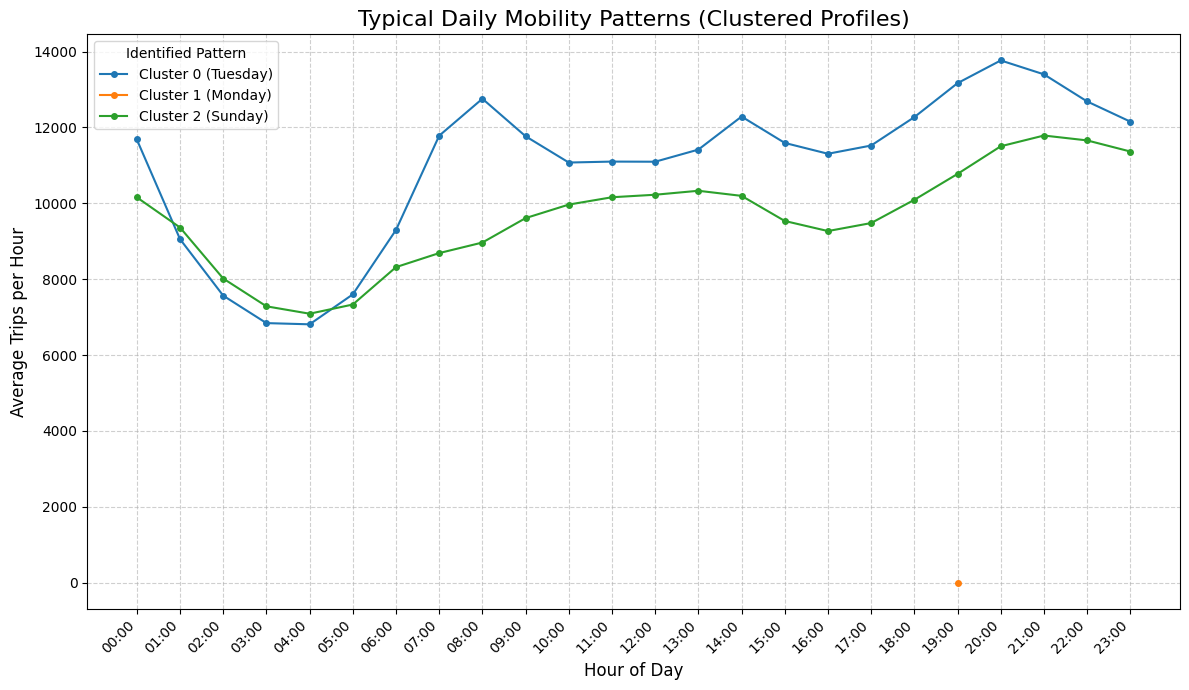

In [22]:
import matplotlib.pyplot as plt

# --- Query the data for plotting ---
print("Querying typical day demand data...")

# 1. RE-REGISTER the view 
# (Necessary because the previous cell unregistered it, but we need it to calculate labels)
con.register('view_dim_clusters', df_results)

# 2. Query: Calculate labels dynamically from the view and join with the Gold table
query = """
WITH cluster_labels AS (
    SELECT 
        cluster_id, 
        -- Calculate day name on the fly since we are using the view
        MODE(dayname(date)) as label
    FROM view_dim_clusters
    GROUP BY cluster_id
)
SELECT 
    t.hour,
    -- Create a readable label for the legend: "Cluster 0 (Sunday)"
    'Cluster ' || t.cluster_id || ' (' || l.label || ')' as pattern_name,
    t.avg_trips
FROM lakehouse.gold.typical_day_by_cluster t
JOIN cluster_labels l ON t.cluster_id = l.cluster_id
ORDER BY t.hour;
"""

demand_df = con.execute(query).df()

if demand_df.empty:
    print("ERROR: 'gold.typical_day_by_cluster' table is empty. No data to plot.")
else:
    # --- Prepare data for plotting ---
    print("Pivoting data for plotting...")
    # Pivot: Index=Hour, Columns=Pattern Name, Values=Average Trips
    pivot_df = demand_df.pivot(index='hour', columns='pattern_name', values='avg_trips')
    
    # --- Create the plot ---
    print("Generating plot with matplotlib...")
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Plot the data
    pivot_df.plot(kind='line', ax=ax, marker='o', markersize=4)
    
    ax.set_title('Typical Daily Mobility Patterns (Clustered Profiles)', fontsize=16)
    ax.set_xlabel('Hour of Day', fontsize=12)
    ax.set_ylabel('Average Trips per Hour', fontsize=12)
    
    # Set x-ticks to be clear
    ax.set_xticks(range(0, 24))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45, ha='right')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add legend
    ax.legend(title='Identified Pattern')
    
    # Ensure labels are not cut off
    plt.tight_layout()
    
    # Display the plot in the notebook
    plt.show()

# Optional: Clean up again if you want to keep memory clean
con.unregister('view_dim_clusters')

#### Business Question 2: Infrastructure Gaps

In [3]:
# Instalar y cargar la extensión espacial
con.execute("INSTALL 'spatial';")
con.execute("LOAD 'spatial';")

In [4]:
print("Creating Gold table 'gold_infrastructure_gaps'...")

# Ensure spatial extension is loaded for ST_Centroid and ST_Distance_Spheroid
con.execute("INSTALL spatial; LOAD spatial;")

gold_bq2_query = """--sql
CREATE OR REPLACE TABLE lakehouse.gold.gold_infrastructure_gaps AS

WITH od_pairs AS (
    SELECT
        origin_zone_id,
        destination_zone_id,
        SUM(trips) AS total_actual_trips
    FROM lakehouse.silver.fact_mobility
    GROUP BY 1, 2
),

unique_rent AS (
    SELECT 
        zone_id, 
        income_per_capita AS rent
    FROM lakehouse.silver.metric_ine_rent
    WHERE year = 2023
),

model_calculation AS (
    SELECT
        m.origin_zone_id AS org_zone_id,
        m.destination_zone_id AS dest_zone_id,
        p.population AS total_population,               -- P_i
        r.rent,                                         -- E_j
        m.total_actual_trips AS total_trips,            -- Actual trips
        
        -- SPATIAL CHANGE:
        -- 1. We take the Polygon from dim_zones
        -- 2. We calculate the center point (ST_Centroid)
        -- 3. We calculate the distance between centroids in Meters -> KM
        GREATEST(
            0.5, 
            st_distance_spheroid(
                ST_Centroid(z_org.polygon), 
                ST_Centroid(z_dest.polygon)
            ) / 1000 
        ) AS geographic_distance_km
            
    FROM od_pairs AS m
    -- Metrics
    JOIN lakehouse.silver.metric_population AS p ON m.origin_zone_id = p.zone_id
    JOIN unique_rent AS r ON m.destination_zone_id = r.zone_id
    
    -- GEOMETRY JOINS: We join dim_zones twice to get the shapes
    JOIN lakehouse.silver.dim_zones as z_org ON m.origin_zone_id = z_org.zone_id
    JOIN lakehouse.silver.dim_zones as z_dest ON m.destination_zone_id = z_dest.zone_id

    -- Filters
    WHERE p.population > 0 
      AND r.rent > 0
      AND z_org.polygon IS NOT NULL
      AND z_dest.polygon IS NOT NULL
      AND m.origin_zone_id != m.destination_zone_id -- Avoid intra-zone trips
)

SELECT
    org_zone_id,
    dest_zone_id,
    total_trips,
    total_population,
    rent,
    geographic_distance_km,
    
    -- Gravity Model T_ij = k * (P_i * E_j) / (d_ij^2)
    (1.0 * (CAST(total_population AS DOUBLE) * CAST(rent AS DOUBLE))) / 
    (geographic_distance_km * geographic_distance_km) AS estimated_potential_trips,
        
    -- Mismatch Ratio
    total_trips / NULLIF(estimated_potential_trips, 0) AS mismatch_ratio,
    CURRENT_TIMESTAMP as processed_at

FROM model_calculation;
"""

con.execute(gold_bq2_query)
print("✓ Table 'gold.gold_infrastructure_gaps' created.")

# --- Verification ---
print("\n--- Verification: Top 10 Zones with 'Mismatch' ---")
verification_bq2 = """--sql
    SELECT 
        org_zone_id,
        dest_zone_id,
        total_trips,
        estimated_potential_trips,
        geographic_distance_km,
        mismatch_ratio
    FROM lakehouse.gold.gold_infrastructure_gaps
    WHERE total_trips > 10
    ORDER BY mismatch_ratio ASC
    LIMIT 10;
"""
display(con.execute(verification_bq2).df())

Creating Gold table 'gold_infrastructure_gaps'...
✓ Table 'gold.gold_infrastructure_gaps' created.

--- Verification: Top 10 Zones with 'Mismatch' ---


,org_zone_id,dest_zone_id,total_trips,estimated_potential_trips,geographic_distance_km,mismatch_ratio
0,352,328,36.0,1.528625e+06,37.588703,0.000024
1,52,2277,17.0,6.626675e+05,78.912743,0.000026
2,423,357,16.0,3.972335e+05,34.798519,0.000040
3,1467,2227,76.0,1.542860e+06,23.853850,0.000049
4,368,1288,20.0,3.691028e+05,103.212808,0.000054
5,404,478,20.0,3.515124e+05,34.835349,0.000057
6,378,499,20.0,3.152771e+05,15.137951,0.000063
7,2353,2270,33.0,4.692699e+05,17.563489,0.000070
8,1420,1848,32.0,4.542498e+05,323.758943,0.000070
9,1407,1027,24.0,2.985903e+05,12.752512,0.000080


In [5]:
query="""SELECT zone_id, zone_name FROM lakehouse.silver.dim_zones WHERE zone_id IN(2402, 1131);"""
con.execute(query).df()

,zone_id,zone_name
0,1131,Grañén agregacion de municipios
1,2402,València


# Close connection

In [23]:
print("--- 📜 Transaction Log (Snapshots) ---")
# This shows the ID, Timestamp, and usually the schema/table changed
snapshots_df = con.execute("SELECT * FROM lakehouse.snapshots() ").df()
print(snapshots_df)

--- 📜 Transaction Log (Snapshots) ---
    snapshot_id                    snapshot_time  schema_version  \
0             0 2025-12-07 17:56:22.394311+01:00               0   
1             1 2025-12-07 17:56:22.485542+01:00               1   
2             2 2025-12-07 17:56:22.521665+01:00               2   
3             3 2025-12-07 17:56:22.559957+01:00               3   
4             4 2025-12-07 17:56:25.257959+01:00               4   
..          ...                              ...             ...   
64           64 2025-12-07 18:10:55.195672+01:00              32   
65           65 2025-12-07 18:10:56.521131+01:00              32   
66           66 2025-12-07 18:10:57.982167+01:00              32   
67           67 2025-12-07 18:11:00.823551+01:00              32   
68           68 2025-12-07 18:11:50.489489+01:00              33   

                                                                                changes  \
0                                                     

In [24]:
con.close()